In [20]:
#importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from datetime import datetime, timedelta


C:\Users\AbdulRafay\AppData\Local\Temp\ipykernel_9164\3563653030.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cakes_data['Date'] = pd.to_datetime(cakes_data['Date'])


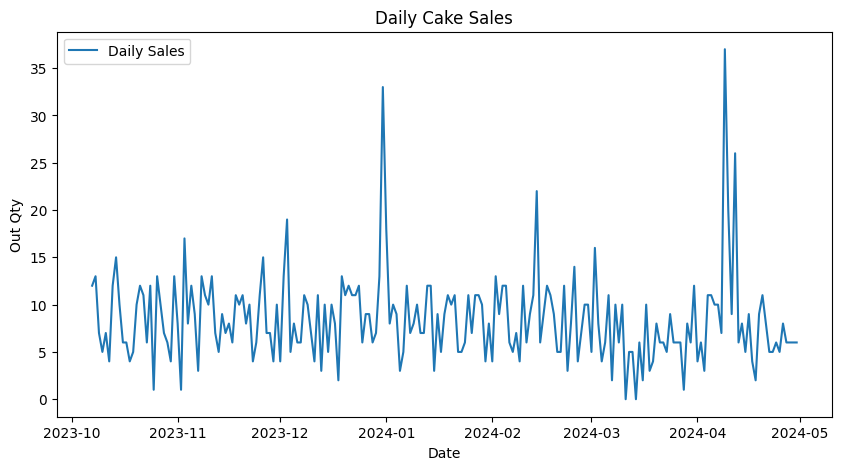

In [21]:
#Load and Pre-process the data
# Load the data
data = pd.read_csv('cakes_actual_girja_8_to_8.csv')

# Filter data for cakes (assuming item_name for cakes is 'cake')
cakes_data = data[data['item_name'] == 'Belgian Chocolate 2.5 LBS']

# Convert 'Date' column to datetime
cakes_data['Date'] = pd.to_datetime(cakes_data['Date'])

# Filter data for the last 6 months
start_date = '2023-10-07'
end_date = '2024-04-30'
filtered_data = cakes_data[(cakes_data['Date'] >= start_date) & (cakes_data['Date'] <= end_date)]

# Aggregate data by date
daily_sales = filtered_data.groupby('Date').agg({'Out Qty': 'sum'}).reset_index()
daily_sales.set_index('Date', inplace=True)

# Visualize the data
plt.figure(figsize=(10, 5))
plt.plot(daily_sales, label='Daily Sales')
plt.title('Daily Cake Sales')
plt.xlabel('Date')
plt.ylabel('Out Qty')
plt.legend()
plt.show()


In [22]:
#create sequence for LSTM
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_sales)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 14  # Using past 14 days to predict the next day
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}, {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, {y_test.shape}')


Training data shape: (154, 14, 1), (154, 1)
Testing data shape: (39, 14, 1), (39, 1)


In [23]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=20)


Epoch 1/20
154/154 [==============================] - 4s 7ms/step - loss: 0.0139
Epoch 2/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0139
Epoch 3/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0144
Epoch 4/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0140
Epoch 5/20
154/154 [==============================] - 1s 6ms/step - loss: 0.0136
Epoch 6/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0138
Epoch 7/20
154/154 [==============================] - 1s 6ms/step - loss: 0.0138
Epoch 8/20
154/154 [==============================] - 1s 6ms/step - loss: 0.0138
Epoch 9/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0133
Epoch 10/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0138
Epoch 11/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0138
Epoch 12/20
154/154 [==============================] - 1s 6ms/step - loss: 0.0133
Epoch 13/20
154/154 [====

2/2 [==============================] - 1s 0s/step
Mean Absolute Error (MAE): 3.6441401701707106
Mean Squared Error (MSE): 41.12974094099458
Root Mean Squared Error (RMSE): 6.413247300782544


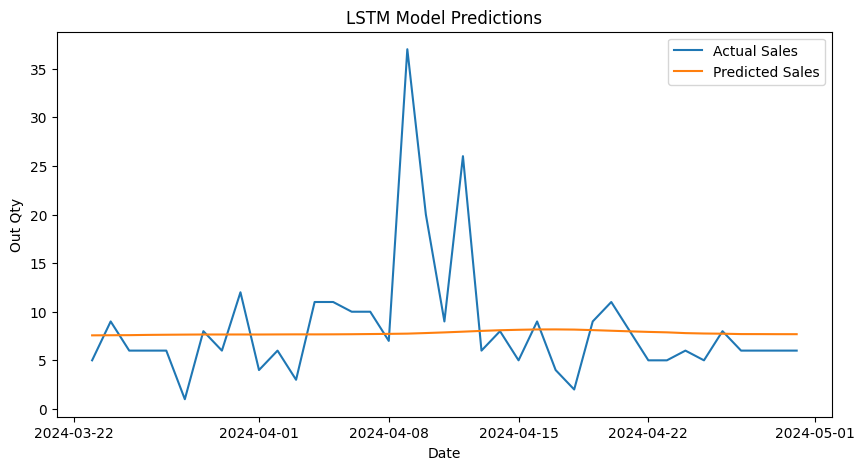

In [24]:
# Predict on the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverse the normalization

# Get the actual sales values
y_test_actual = scaler.inverse_transform(y_test)

# Calculate and print accuracy metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = math.sqrt(mse)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Visualize the predictions
plt.figure(figsize=(10, 5))
plt.plot(daily_sales.index[-len(y_test):], y_test_actual, label='Actual Sales')
plt.plot(daily_sales.index[-len(y_test):], predictions, label='Predicted Sales')
plt.title('LSTM Model Predictions')
plt.xlabel('Date')
plt.ylabel('Out Qty')
plt.legend()
plt.show()


1/1 [==============================] - 0s 24ms/step


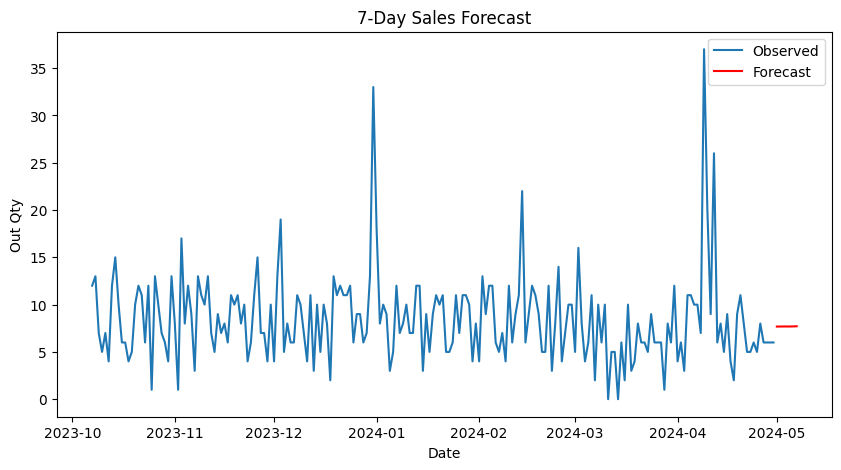

Forecasted sales for the next 7 days:
2024-05-01    7.681509
2024-05-02    7.684293
2024-05-03    7.691280
2024-05-04    7.689335
2024-05-05    7.689259
2024-05-06    7.698077
2024-05-07    7.712941
dtype: float32


In [25]:
# Get the last sequence for forecasting
last_sequence = scaled_data[-seq_length:]

# Forecast the next 7 days
forecast = []
current_sequence = last_sequence
for _ in range(7):
    prediction = model.predict(current_sequence.reshape(1, seq_length, 1))
    forecast.append(prediction[0][0])
    current_sequence = np.append(current_sequence[1:], prediction[0][0]).reshape(seq_length, 1)

# Reverse the normalization
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Create a date range for the forecast
forecast_dates = [daily_sales.index[-1] + timedelta(days=i) for i in range(1, 8)]
forecast_series = pd.Series(forecast.flatten(), index=forecast_dates)

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(daily_sales, label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('7-Day Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Out Qty')
plt.legend()
plt.show()

# Output the forecasted values
print("Forecasted sales for the next 7 days:")
print(forecast_series)

In [ ]:
# import numpy as np

# # Your actual and predicted values
# y_test_actual = np.array([6, 6, 9, 9, 3, 4, 2])
# predictions = np.array([7.681509, 7.684293,  7.691280, 7.689335, 7.689259, 7.698077, 7.712941])

# # Calculate MAPE
# mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

# # Calculate accuracy
# accuracy = 100 - mape

# print(f'MAPE: {mape:.2f}%')
# print(f'Accuracy: {accuracy:.2f}%')
